# 'Swan Teleco: Customer Retention Analysis'
## <i> by Team Churners
### Exploration and prediction of the Swan database for churning of customers.
This notebook includes:

<b> 1. Exploratory Data Analysis </b>
- Checks, null handling, cleaning & visuals

<b> 2. Modelling Churn Risk </b>
- FE, scaling, training different models for comparison, calculating and comparing metrics 

<b> 3. Extracting the customer lists most likely to churn </b>
- Using the best model extracting a list of all/top 500 most likely to churn customers

## 0. Imports

In [1]:
# Import statements and set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch

# Import machine learning related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,  roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Set the visual style for plots
two_palette=['#2c3e6c', '#b0c4de']
three_palette = ['#2c3e6c', '#b0c4de', '#98A8B6']
five_palette = ['#2c3e6c', '#b0c4de', '#98A8B6', '#7F8C8D', '#2A2A2A']

## 1. Exploratory Data Analysis
### 1.1. Initial Checks
- Explore the dataset for anomalous data, as well as establish basic insights into which type of customers are likely to churn and why?

In [2]:
df = pd.read_csv("Project_Data.csv")
print("Data Shape:", df.shape)
print("Data Nulls:\n", df.isna().sum())

Data Shape: (7043, 31)
Data Nulls:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64


<b> Insight into Nulls: </b>
- Investigation into the huge number of nulls for 'Churn Reason' showed that these nulls are solely for the reason 'when the customer has not churned', which is completely logical and suggests the data is still consistent even if it has these nulls.

In [3]:
# The churn value is 0 where the Churn Reason is null which makes sense
nullReason = df[df['Churn Reason'].isna()].copy()
nullReason['Churn Value'].value_counts()

Churn Value
0    5174
Name: count, dtype: int64

### 1.2. Renaming columns
- Rename the variables to more standard coding practices.

In [4]:
# Rename columns at this point for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

### 1.3. Demographics of churners

- Explore relationships between churners and different features within the dataset through visualisations.
- Prior to this, normalise the values within the graph to get a percentage of the total number of people who did or didn't churn. Here is the mathematical calculation for context:

   $\text{Percentage(\%) = \text{Count of entries with flag in that column} / \text{Count of total entries with flag}}$

Firstly, we visualise the churn rate against demographics of customers like gender, seniorship or having a partner or dependents.

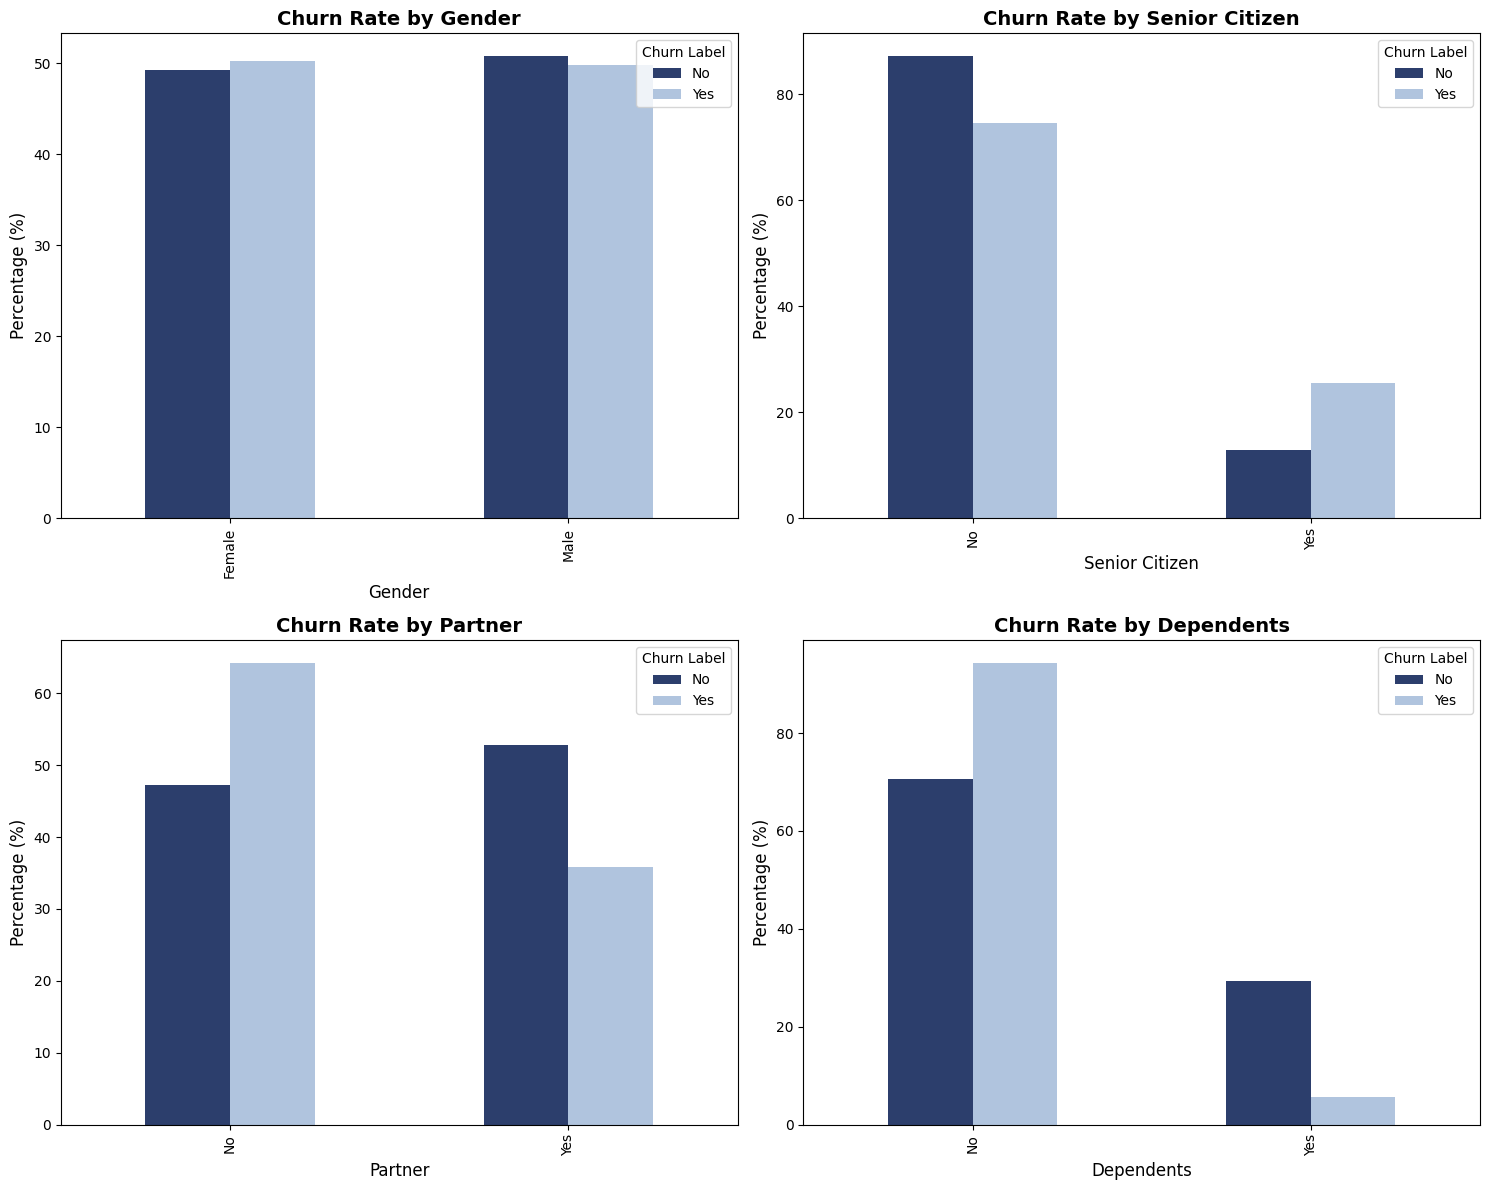

In [5]:
# Demographic Analysis
columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Insights into Demographics of churners:
- *Gender* does not seem to have an effect on someone churning.
- *Senior citizens* have a higher chance of churning.
- People with *partners* or *dependents* exhibit much stronger loyalty.

Review how different contractual/financial obligations affect on churning of customers.

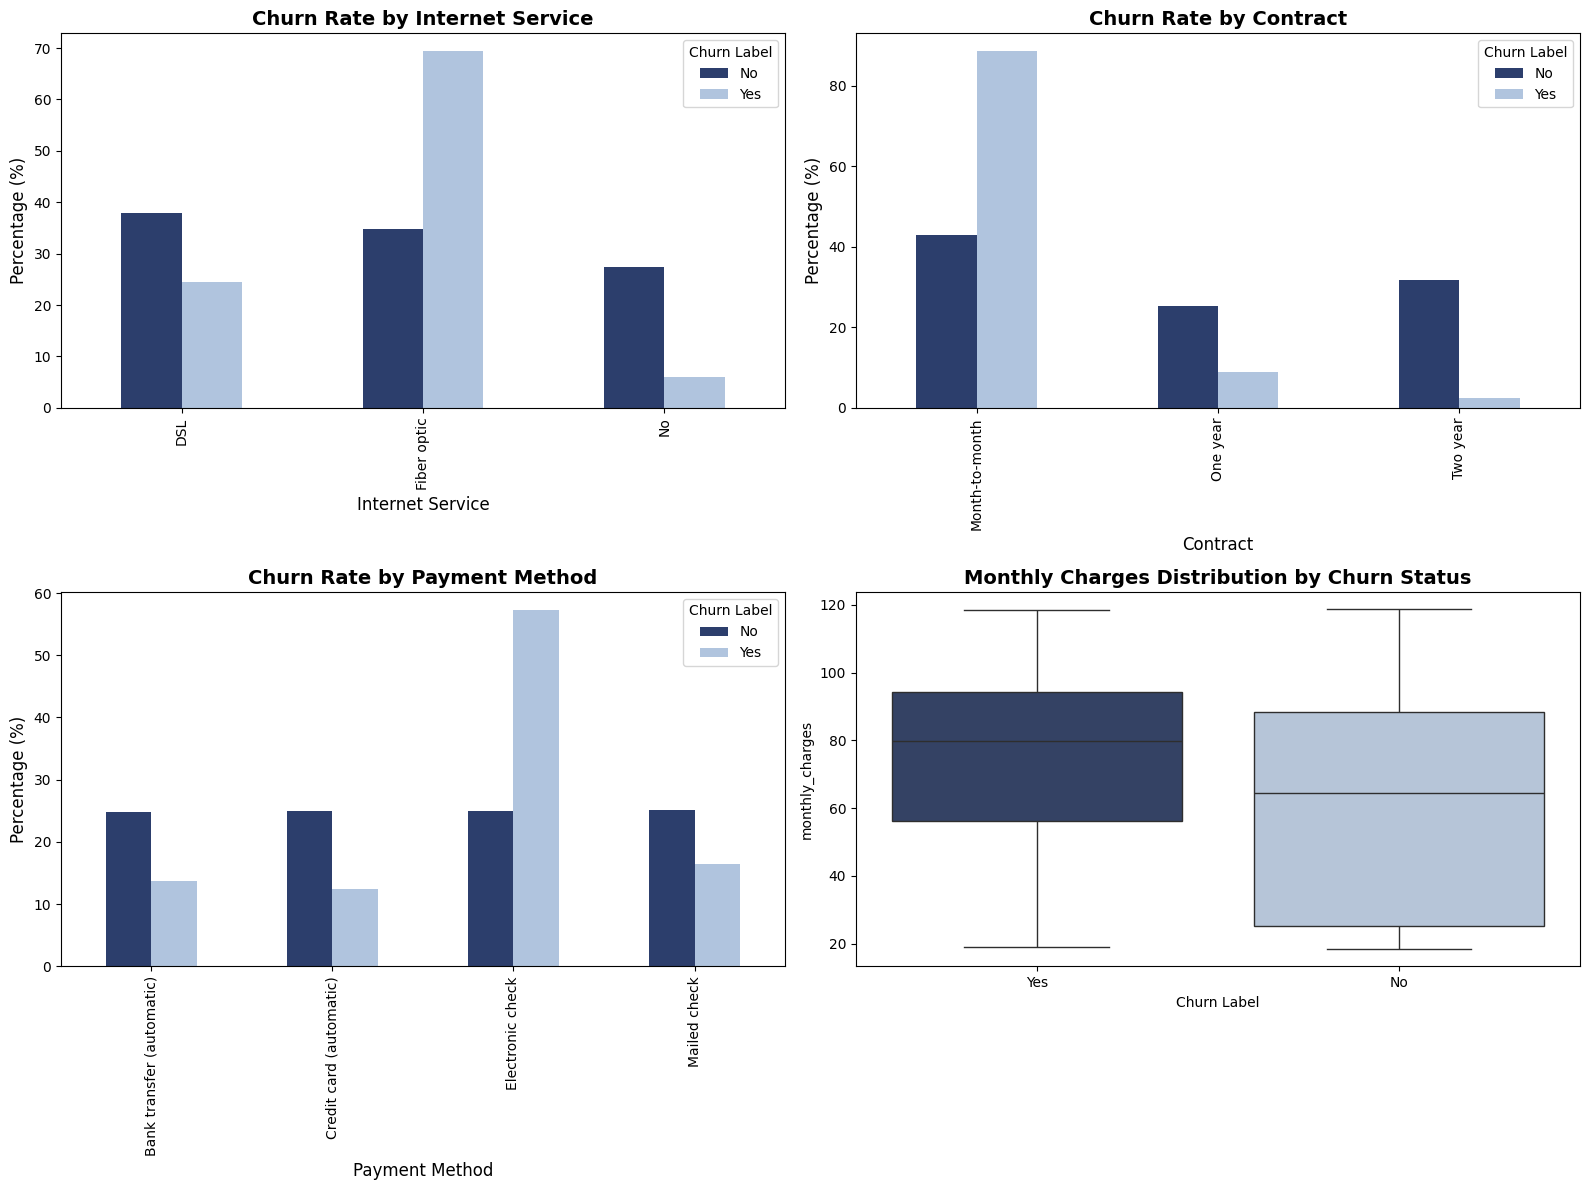

In [6]:
# Payment Method, Internet Service & Contract type Analysis
columns = ['Internet Service', 'Contract', 'Payment Method']
# Service Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

sns.boxplot(data=df, x='churn_flag', y='monthly_charges', ax=axes[3], palette=two_palette, hue = 'churn_flag')
axes[3].set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Churn Label')

plt.tight_layout()
plt.show()

Insights into Services:

Customers on month-to-month contracts, using electronic billing, and subscribing to fiber optic services demonstrate the highest churn rates.
- *Fiber optic*: Highest churn rate on this category. The company can invest in making the service better for customers to reduce churning within this area.
- *Month to month*: The customers most likely to churn are those who value flexibility i.e, these individuals tend to prioritise convenience and short-term control over long-term commitment, making them more responsive to competitive offers and more willing to switch providers.
- *Electronic checks*: The fact that the electronic checks are manual hence have a high churn rate then automatic bank cards payments that have a much lower churn rate.
- *High average monthly charges*: Customers are more inclined to churn if they are paying more, most likely swayed by competitors' better offers.
Overall, the visuals show that while flexibility attracts new customers, it also lowers switching costs and weakens loyalty. This suggests that Swan’s most at-risk segment consists of high-speed, digitally active customers who prefer minimal contractual obligation.

It is also important to review add-ons offered by Swan Teleco, specific to the customers who opt for *Internet Service scheme*. This will help to review which of these add-ons can help reduce churning.

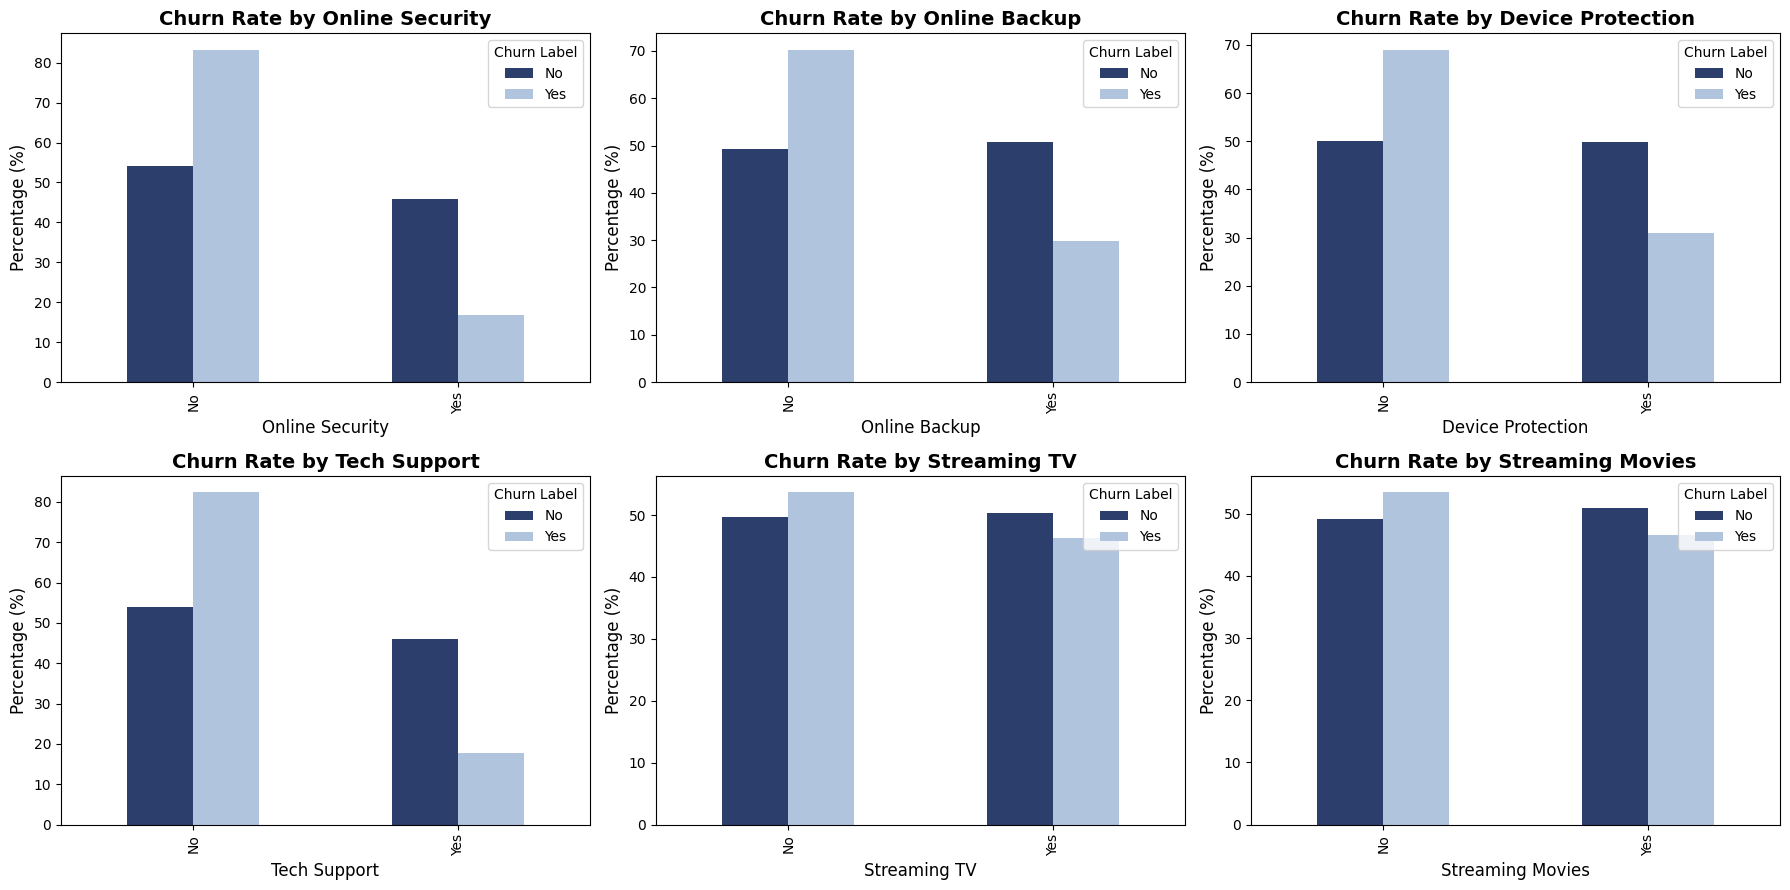

In [7]:
# Add on columns to analyze
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

# Remove rows where InternetService is 'No'
df_internet = df[df['Internet Service'] != 'No']

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df_internet[col], df_internet['churn_flag'], normalize='columns') * 100

    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Insights into add-ons for customers using *Internet Service*

It can be seen that tech add ons such as:
- *Online security*
- *Online backup*
- *Device protection*
- *Tech support*

All reduce churn rate, whereas *TV & Movie streaming services* do not reduce churn by a noticeable amount.

Next it is also important to reveiw behaviours of the other set of customers i.e, with *Phone Service scheme*, along with the add-on of *Multiple Lines* to see if these have any impact on churning.

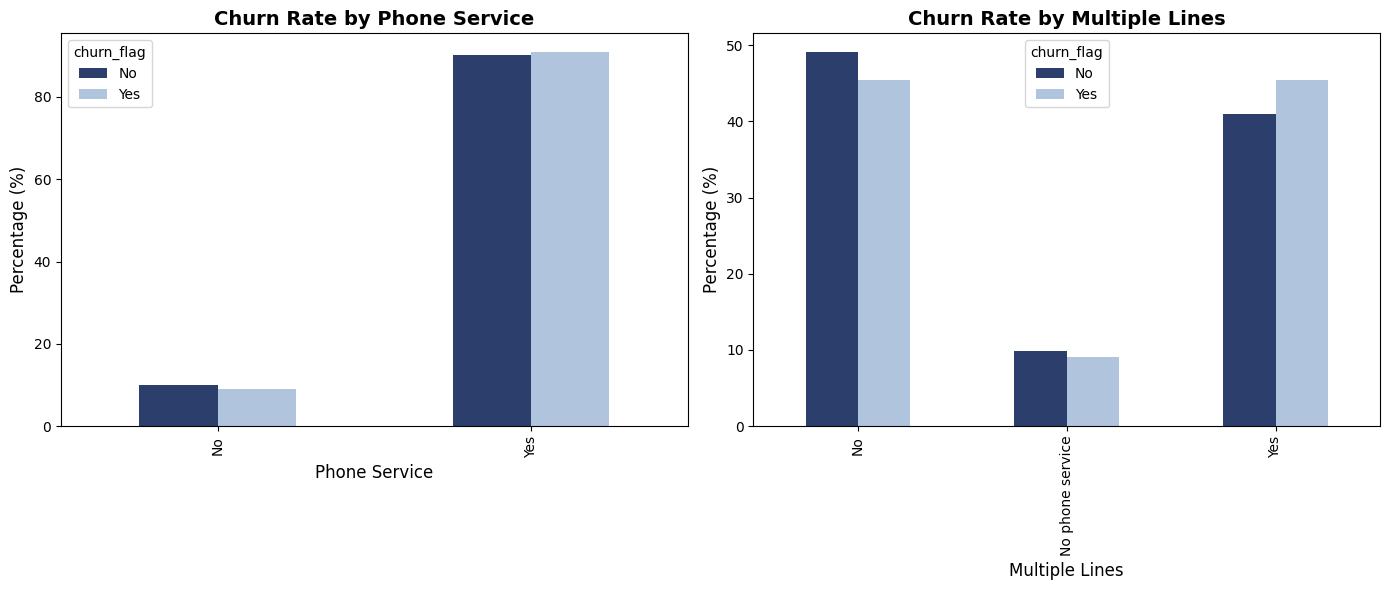

In [8]:
# Phone service columns to analyze
columns = ['Phone Service', 'Multiple Lines']

# Create subplots
fig, axes = plt.subplots(1, len(columns), figsize=(14, 6))

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100

    # Create horizontal bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

Insight into customers with *Phone Service*

- Neither *Phone Service* nor *Multiple lines* seem to affect churn by a reasonable amount, and so can be disregarded as potential impactors of churning.

It is also important to review *tenure duration* with respect to churn rate, to analyse how customers churning changes with time spent with the service.

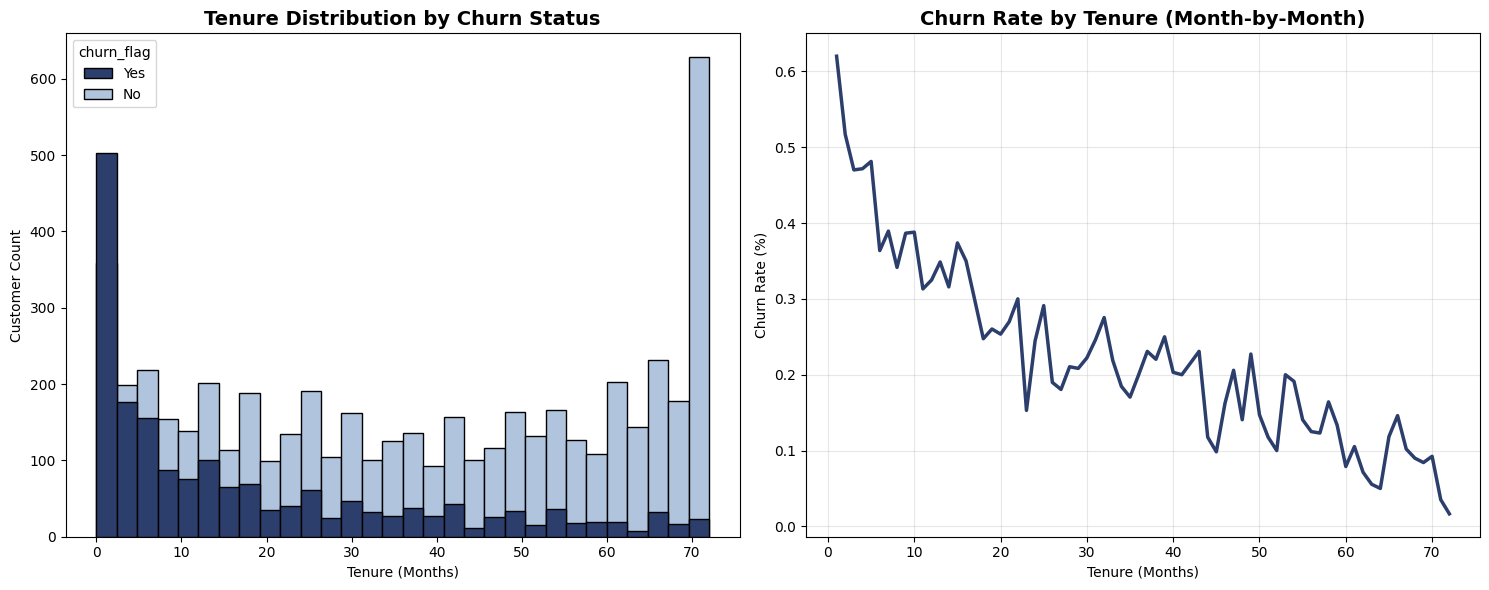

In [9]:
# Tenure Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LHS
sns.histplot(
    data=df,
    x='tenure_months',
    hue='churn_flag',
    bins=30,
    ax=axes[0],
    palette=two_palette,
    alpha=1
)
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tenure (Months)')
axes[0].set_ylabel('Customer Count')

# RHS
tenure_month_churn = (
    df.groupby('tenure_months')['churn_value']
    .mean()
    .reset_index()
    .rename(columns={'churn_value': 'churn_rate'})
)
tenure_month_churn = tenure_month_churn[tenure_month_churn['tenure_months'] > 0]
sns.lineplot(
    data=tenure_month_churn,
    x='tenure_months',
    y='churn_rate',
    ax=axes[1],
    color='#2c3e6c',
    linewidth=2.5
)
axes[1].set_title('Churn Rate by Tenure (Month-by-Month)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Insights into *Tenure distribution*

- As seen from the graphs *'Tenure'* is another defining factor. Churn risk is highest during the 
first few months, declining sharply afterwards.This pattern suggests that early-stage experience
and onboarding quality are critical determinants of long-term retention.
- Swan Teleco's customers who remain beyond their first month are significantly less likely to churn, highlighting a key window for engagement and service reinforcement.

Having reviewed different demographics of churners, along with the effect of services on customer retention rates, it is important to specifically highlight what features are driving customers to churn.

### 1.3. Churn Drivers
- Investigate the top reasons that led customers to churn

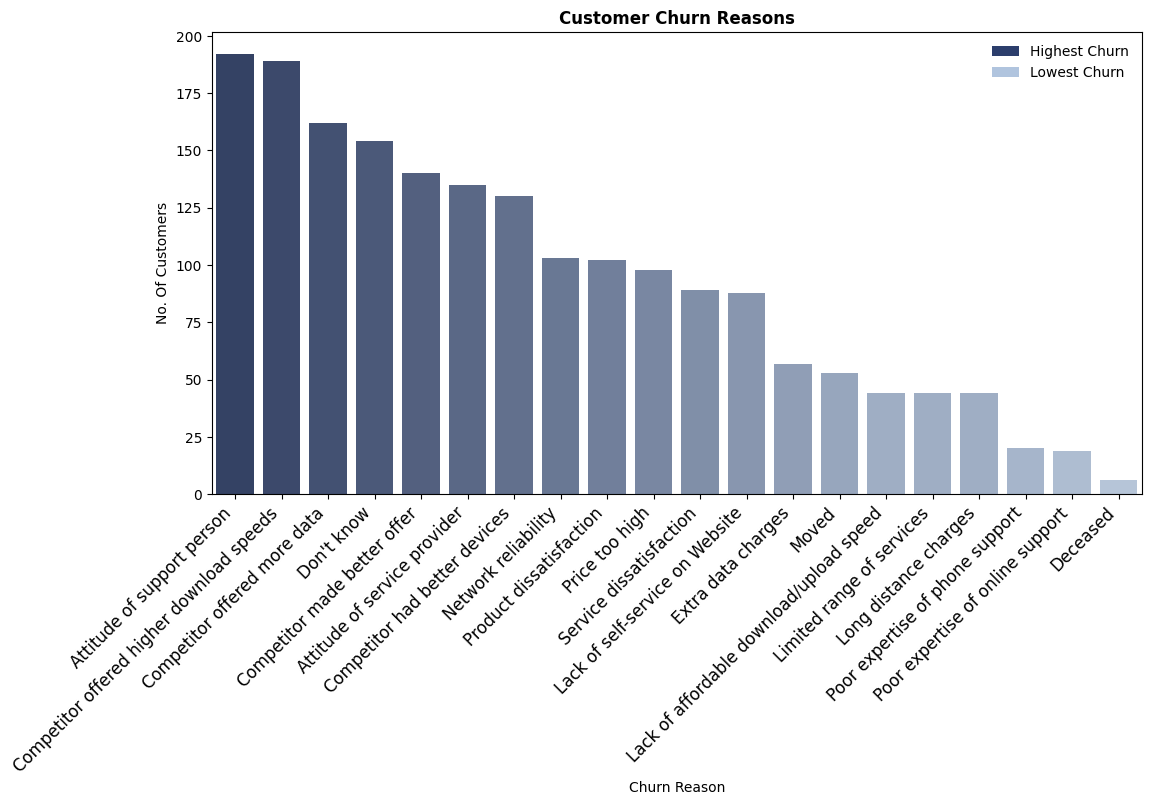

In [10]:
# Graphing the top reasons customers gave for churning

# Convert hex to RGB tuples
start_rgb = to_rgb(five_palette[1])
end_rgb = to_rgb(five_palette[0])

# Create a custom palette by interpolating between the two
n_colors = 18  # Number of colors in the palette
palette = [
    (
        start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (n_colors - 1),
        start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (n_colors - 1),
        start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (n_colors - 1)
    )
    for i in range(n_colors)
]
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette=palette, hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons', fontweight='bold')
# Create custom legend with first and last colors
legend_elements = [
    Patch(facecolor=palette[-1], label='Highest Churn'),
    Patch(facecolor=palette[0], label='Lowest Churn')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

Insights into *Customer Reasons for churning*

Top reasons customers provided by customers for leaving Swan Teleco are:

- Disappointing attitude from customer support.
- Competitive offers providing a better a deal for the user.

These finidngs reinforce that many customers leave not only for lower prices, but because competitors deliver a smoother experience or stronger perceived value. Addressing this through better-trained support teams, improved service reliability and performance, will greatly strengthen loyalty and reduce churn.

Having gathered this insight, let's build a correlation of different features to *churn_value* 
- A negative correlation implies a feature that pushes customers to stay and,
- A positive correlation being a feature that does the opposite.

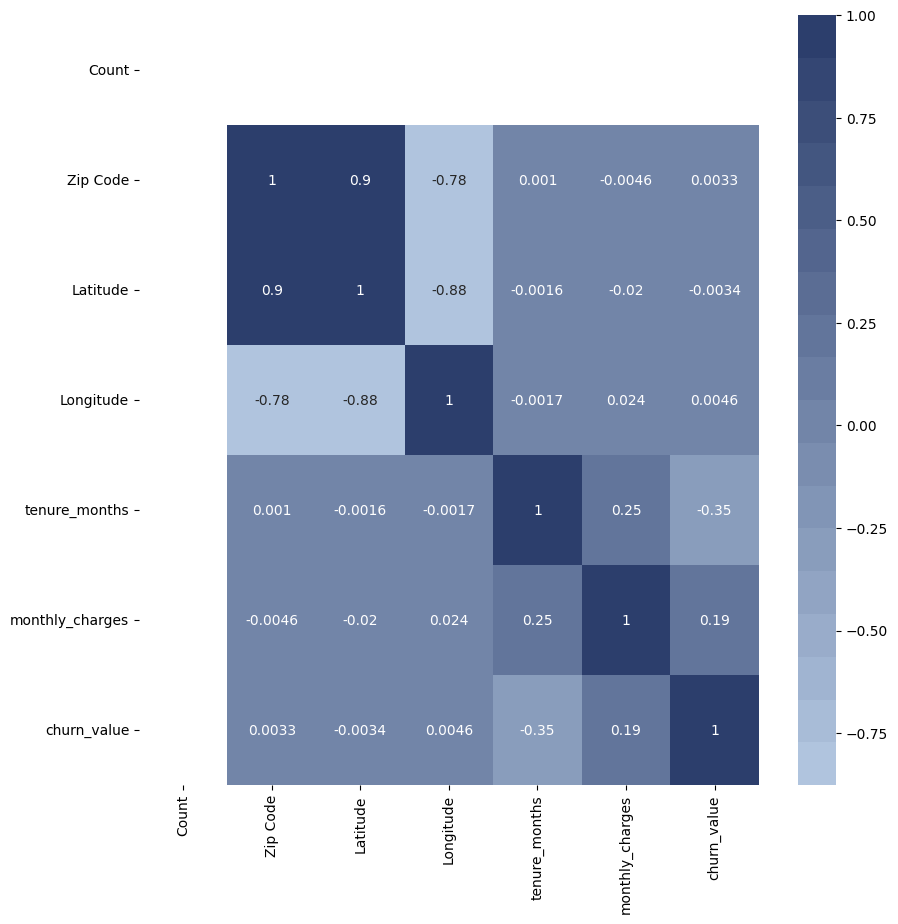

In [11]:
# Creating correlation to see what factors have a negative correlation with churn value.
plt.figure(figsize = (10,10))
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = palette, 
            annot = True)
plt.show()

In [12]:
# Creating churn rate summary table
def churn_rate_summary_fixed(df, features, churn_col='churn_flag'):
    """
    Creates a table with churn % for 'Yes' and 'No' values and Δ%.
    Handles columns with 'No internet service' or 'No phone service'.
    """
    results = []

    df_local = df.copy()

    # Normalize "No internet service"/"No phone service" → "No"
    df_local = df_local.replace({
        'No internet service': 'No',
        'No phone service': 'No'
    })

    for col in features:
        if col not in df_local.columns:
            continue

        churn_table = (
            df_local.groupby(col)[churn_col]
            .apply(lambda x: (x == 'Yes').mean() * 100 if df[churn_col].dtype == 'object' else x.mean() * 100)
        )

        yes_rate = churn_table.get('Yes', np.nan)
        no_rate  = churn_table.get('No', np.nan)
        delta    = yes_rate - no_rate if (not np.isnan(yes_rate) and not np.isnan(no_rate)) else np.nan

        results.append({
            'Feature': col,
            'Churn % (Yes)': round(yes_rate, 2) if not np.isnan(yes_rate) else None,
            'Churn % (No)': round(no_rate, 2) if not np.isnan(no_rate) else None,
            'Δ % (Yes - No)': round(delta, 2) if not np.isnan(delta) else None
        })

    return pd.DataFrame(results).sort_values(by='Δ % (Yes - No)', ascending=False).reset_index(drop=True)


# Include both demographics & service features
features = [
    'Paperless Billing', 'Phone Service', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

summary_table = churn_rate_summary_fixed(df, features)
summary_table

,Feature,Churn % (Yes),Churn % (No),Δ % (Yes - No)
0,Paperless Billing,33.57,16.33,17.24
1,Streaming TV,30.07,24.33,5.74
2,Streaming Movies,29.94,24.38,5.56
3,Multiple Lines,28.61,25.02,3.59
4,Phone Service,26.71,24.93,1.78
5,Device Protection,22.50,28.65,-6.15
6,Online Backup,21.53,29.17,-7.64
7,Tech Support,15.17,31.19,-16.02
8,Online Security,14.61,31.33,-16.72


Key insight

- The summary table provide the delta difference between the churn rates for several important features, as well as providing a strong figure to include within our information deck. Here, a positive value implies that it is a feature that can be seen to lead customers to churn, and the opposite for features with a negative difference.

### Exploratory Data Analysis Conclusion
To summarise our primary findings from our EDA, we conclude that:
* In regards to demographics, the main takeaways are that *senior citizens* are the primary area for concern in regards to a higher churn rate.
* Customers who have *Fibre Optic*, as well as ones who are under a month to month contract are both likely to churn and may need incentives to stay. This could come in the form of raising awareness about the benefits of brand loyalty. This also matches well with the fact that *Tenure Months* were found to be the biggest negative correlator to people churning, which means that it is a strong incentive that leads to people staying.
* *Tech add ons* such as Online Security and Backup all seem to be effective to reduce churn, whilst streaming add ons do not have much of an impact.
* The primary reasons given by customers for churning came down to *disappointment in customer support*, or better offerings from competitors. Thus, if there was an area to focus on competitive offerings, it would be best in improving the service potentially to customers who are using Fibre Optic.

With the data explored and insights established, it's time to build different models to ensure we have an optimal method to generate the risk of any specific customer churning.

## 2. Modelling Churn Risk
Building different models to select the best that can help make the most reliable prediction of customers with their potential risk of churning.

This innvoles the following steps:
* Feature engineering non-numerical features
* Dropping features not used in modelling
* Splitting the data into a training and testing set to evaluate performace accurately
* Filling missing values
* Scaling the data
* Train a random forest model
* Train a logistic regression model
* Calculate some metrics to compare the models
* Select best on accuracy & f1 score 

### 2.1. Feature Engineering

In [13]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies', 'Internet Service',
        'Contract', 'Payment Method'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local

df_eng = feature_engineering(df)

In [14]:
# Features and target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason',
    'Internet Service',
    'Contract',
    'Tenure Group',
    'Count'
    'churn_risk',
    'churn_risk_log'
    ] # We extract any features that are objects to avoid mislabelling them, along with the target.

X = df_eng.drop(columns=drop_cols, errors='ignore')

y = df_eng['churn_flag']

### 2.2 Split our data

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3. Fill missing values

In [16]:
### Fill missing values
median = X_train.loc[~(X_train['total_charges'] == ' ')]['total_charges'].astype('float').median() # Calculate the median 'total_charges' of the non 'empty' values in our training data
print(f'The median value of total charges is {median}')  # Display the median
X_train['total_charges'] = X_train['total_charges'].replace({' ': median}) # Replace the empty values with the median
X_test['total_charges'] = X_test['total_charges'].replace({' ': median}) # same but with test data

The median value of total charges is 1388.0


### 2.4. Scale our data

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit our scaler on training data, and then transofrm our training data
X_test_scaled = scaler.transform(X_test)  # Transofrm the testing data, using the scaling from the **Training** data

### 2.5. Define an evaluation function

In [18]:
## There are 4 main metrics we're interested in at this stage: 
#accuracy, precision, recall and F1.
## The 'metrics' module from sklearn covers all of them (and more!) 
#So we can use a function like the one below

def get_results(actual, predicted):
    print("\nResults:\n")
    print("The confusion matrix for your predictions is:")
    print(confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {recall_score(actual, predicted, pos_label='Yes')}')
    print(f'The precision of your model is: {precision_score(actual, predicted, pos_label='Yes')}')
    print(f'The F1-score of your model is: {f1_score(actual, predicted, pos_label='Yes')}')

### 2.5. Train our Random Forest Model


Results:

The confusion matrix for your predictions is:
[[914  95]
 [181 219]] 

The accuracy of your model is: 0.8041163946061036
The recall of your model is: 0.5475
The precision of your model is: 0.697452229299363
The F1-score of your model is: 0.6134453781512605
ROC AUC: 0.854359514370664


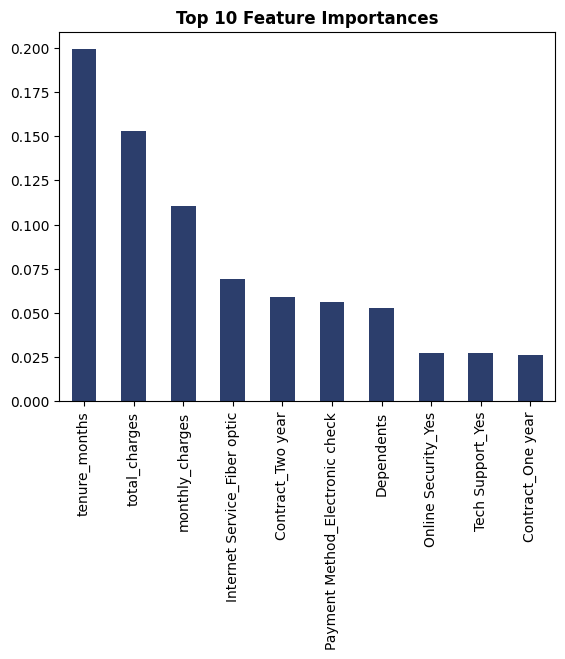

In [19]:
# Random Forest
# rf = RandomForestClassifier(n_estimators = 50)
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', None]
# }
# gs = GridSearchCV(rf, param_grid, cv=5)
# gs.fit(X_train_scaled, y_train)
# print(gs.best_score_)

# gs.best_params_
# ^- the above piece of code generated the following parameters as optimal, but is excluded due to its slightly lengthy runtime of ~1 minute
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, max_features = 'sqrt', min_samples_split = 5)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation
get_results(y_test, y_pred)
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances", fontweight='bold')
plt.show()

Insight:
- Notice that tenure months and the two charges columns are the most significant. This makes sense from our EDA, the total_charges is likely to be strongly correlated with the tenure_months.

### 2.6. Train our Logisitic Regression Model

In [26]:
# Logistic Regression

log_reg = LogisticRegression(max_iter=1000)  # Initialise a log reg model

param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg', 'saga'], 'C': [0.01, 0.1, 1, 10]},
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10]}
]

# This is a set of paramater combinations to check which gives the highest paramater, note that some solvers only work
# with specific penalty's hence the two dictionaries given 

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')  # Perform the Grid Search aiming to maximise accuracy

grid_search.fit(X_train_scaled, y_train) # Fit a model with our found parameters

y_pred_log = grid_search.predict(X_test_scaled) # Generate some predictions

y_prob_log = grid_search.predict_proba(X_test_scaled)[:, 1]  # Generate the probabilities associated with the predictions

# Evaluation
get_results(y_test, y_pred_log)
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))



Results:

The confusion matrix for your predictions is:
[[900 109]
 [169 231]] 

The accuracy of your model is: 0.8026969481902059
The recall of your model is: 0.5775
The precision of your model is: 0.6794117647058824
The F1-score of your model is: 0.6243243243243243
ROC AUC: 0.8539358275520318


### 2.7. Train a SVM Model

In [ ]:
from sklearn import svm

svm_model = svm.SVC()

param_grid = [
    {'C': [0.01, 0.1, 1, 10]}
]

# This is a set of paramater combinations to check which gives the highest para
svm_grid = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')  # Perform the Grid Search aiming to maximise accuracy
svm_grid.fit(X_train_scaled, y_train) # Fit a model with our found parameters

y_pred_svm = svm_grid.predict(X_test_scaled) # Generate some predictions


# Evaluation
get_results(y_test, y_pred_svm)



Results:

The confusion matrix for your predictions is:
[[920  89]
 [181 219]] 

The accuracy of your model is: 0.808374733853797
The recall of your model is: 0.5475
The precision of your model is: 0.711038961038961
The F1-score of your model is: 0.6186440677966102


### 2.8. Compare our Three Models

The models have produced very similar results! However the Random Forest model has a slightly higher accuracy of 0.806 (vs 0.803) and so is to be preferred

## 3. Extracting the customer list

The better model (Random Forest) has been used to create the two lists of customers: 'Top 500 customers likely to churn' as well as 'predictions of all customers likely to churn' for the customer support team. **Note**: The conscious choice is made to only include the *customer ID* within the list of top 500 customers likely to churn as a form of abstraction to ensure that only the information necessary for the mailing list is given.

In [ ]:
ids = df_eng[['customer_id', 'churn_flag']] # Store ids for later
X_final =df_eng.drop(columns=drop_cols, errors='ignore').copy() # Drop columns so that we are using training columns
X_final['total_charges'] = X_final['total_charges'].replace({' ': median}) ## Fill values with the mean of our training data
X_final = scaler.transform(X_final)  # Scale the values using the scaler we used for our training data

df_eng['churn_risk'] = rf.predict_proba(X_final)[:, 1]  # Add a column to our dataframe with the churn risk probability according to our chosen model (random forest)
df_eng['churn_risk_log'] = grid_search.predict_proba(X_final)[:, 1]  # Same thing with logisitic regression model
sorted_by_rf = df_eng.sort_values(by = 'churn_risk', ascending=False)  # Sort values by risk
sorted_by_log = df_eng.sort_values(by = 'churn_risk_log', ascending=False)  # Sort values by risk

In [ ]:
non_churners = sorted_by_rf.loc[sorted_by_rf['churn_flag'] == 'No']  # Select just the customers who haven't churned
top_500_customers = non_churners[['customer_id']].iloc[ :500, : ]  # Extract just the ids of the top 500 customers
top_500_customers.to_csv("top_500_customers.csv", index=False)  # Save that list as a csv

In [ ]:
customer_risk_list = non_churners[['customer_id', 'churn_risk']]  # Select relevent columns of non churners
customer_risk_list.to_csv("customer_churn_risk.csv", index=False)  # Save as a csv